In [1]:
import torch
from torchdiffeq import odeint as odeint


from mpc import mpc
from mpc.mpc import QuadCost, LinDx, GradMethods
from mpc.env_dx import hri

import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt

import os
import io
import base64
import tempfile
from IPython.display import HTML

from tqdm import tqdm

%matplotlib inline

In [3]:
from mpc.env_dx import hri

# Dempster et al. model from @Hwang2015
# For a subject
# - weight = 75 kg
# - thigh length = 0.4 m
# - shank length = 0.4 m

params = {
        "m1": 7.275,
        "m2": 3.75,
        "m3": 2,
        "m4": 2,
        "g": 10,
        "I_G1z": 0.121,
        "I_G2z": 0.055,
        "I_G3z": 0.02,
        "I_G4z": 0.02,
        "l1": 0.4,
        "l2": 0.4,
        "l3": 0.2,
        "l4": 0.2,
        "lc1": 0.173,
        "la1": 0.2,
        "lb1": 0.2,
        "lc2": 0.173,
        "lc3": 0.1,
        "lc4": 0.1,
        "la4": 0.2,
        "la2": 0.2,
        "K_AFz": 2000,
        "K_AFx": 4000,
        "K_AMy": 20,
        "K_BFz": 2000,
        "K_BFx": 2000,
        "K_BMy": 20,
        "D_AFz": 100,
        "D_AFx": 100,
        "D_AMy": 10,
        "D_BFz": 100,
        "D_BFx": 100,
        "D_BMy": 10,
    }

params_wrong = {
        "m1": 5.275,
        "m2": 2.75,
        "m3": 2,
        "m4": 2,
        "g": 10,
        "I_G1z": 0.101,
        "I_G2z": 0.045,
        "I_G3z": 0.02,
        "I_G4z": 0.02,
        "l1": 0.4,
        "l2": 0.4,
        "l3": 0.2,
        "l4": 0.2,
        "lc1": 0.173,
        "la1": 0.2,
        "lb1": 0.2,
        "lc2": 0.173,
        "lc3": 0.1,
        "lc4": 0.1,
        "la4": 0.2,
        "la2": 0.2,
        "K_AFz": 4000,
        "K_AFx": 6000,
        "K_AMy": 20,
        "K_BFz": 4000,
        "K_BFx": 3000,
        "K_BMy": 20,
        "D_AFz": 100,
        "D_AFx": 100,
        "D_AMy": 10,
        "D_BFz": 100,
        "D_BFx": 100,
        "D_BMy": 10,
    }

n_batch, T, mpc_T = 1, 200, 5

dx = hri.HRIDx(model_params=params)
dx_wrong = hri.HRIDx(model_params=params_wrong)

def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

torch.manual_seed(0)
q1 = uniform(n_batch, 0.5*np.pi, 0.5*np.pi)
h_q2 = uniform(n_batch, -0.5*np.pi, -0.5*np.pi)
r_d2 = uniform(n_batch, 0., 0.)
r_d3 = uniform(n_batch, 0., 0.)
r_q4 = uniform(n_batch, 0., 0.)
r_q5 = uniform(n_batch, -0.5*np.pi, -0.5*np.pi)
dq1 = uniform(n_batch, 0., 0.)
h_dq2 = uniform(n_batch, 0., 0.)
r_dd2 = uniform(n_batch, 0., 0.)
r_dd3 = uniform(n_batch, 0., 0.)
r_dq4 = uniform(n_batch, 0., 0.)
r_dq5 = uniform(n_batch, 0., 0.)

# fix
xinit = torch.stack((q1, dq1, h_q2, h_dq2, r_d2, r_dd2, r_d3, r_dd3, r_q4, r_dq4, r_q5, r_dq5), dim=1)

x = xinit
u_init = None

# human_u = 3 * sin(2 * 2 * pi * t / 100)

# The cost terms for the swingup task can be alternatively obtained
# for this pendulum environment with:
# q, p = dx.get_true_obj()


controller = 'mpc'

if controller == 'mpc':
    # Set a template here
    goal_weights = torch.Tensor((0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.))
    goal_state = torch.Tensor((0, 0., 0, 0., 0., 0., 0. , 0., 0. ,0., 0, 0.))
    ctrl_penalty = 0.00001
    q = torch.cat((
        goal_weights,
        ctrl_penalty*torch.ones(dx.n_ctrl)
    ))
    px = -torch.sqrt(goal_weights)*goal_state
    p = torch.cat((px, torch.zeros(dx.n_ctrl)))
    Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
        mpc_T, n_batch, 1, 1
    )
    p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)
elif controller == 'pid':
    accumu_err = 0
else:
    raise ValueError('Invalid controller')
    
print(f"Here Q: {Q.size()}")
print(f"Here p: {p.size()}")

t_dir = tempfile.mkdtemp()
print('Tmp dir: {}'.format(t_dir))

# initialise an array to store the state and action trajectories
x_traj = torch.zeros(T, dx.n_state)
u_traj = torch.zeros(T, dx.n_ctrl)

for t in tqdm(range(T)):
    t_collection = torch.tensor([i for i in range(t, t+mpc_T)])
    des_angle = - np.pi/4 * np.cos(2*np.pi*t_collection/100)- np.pi/4
    human_u = 5 * torch.sin(2 * 2 * torch.pi * t_collection / 100)
    dx.update_input(human_u)
    
    if controller == 'mpc':
        goal_weights = torch.Tensor((0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.))
        goal_states = torch.zeros(mpc_T, dx.n_state)
        pxs = torch.zeros(mpc_T, dx.n_state)
        ps = torch.zeros(mpc_T, dx.n_state + 1)
        for i in range(mpc_T):
            goal_states[i, 0] = np.pi/2
            goal_states[i, 2] = des_angle[i]
            goal_states[i, 10] = des_angle[i]
            pxs[i, :] = -torch.sqrt(goal_weights)*goal_states[i, :]
            ps[i, :] = torch.cat((pxs[i, :], torch.zeros(dx.n_ctrl)))
        ctrl_penalty = 0.00001
        q = torch.cat((
            goal_weights,
            ctrl_penalty*torch.ones(dx.n_ctrl)
        ))
        Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
            mpc_T, n_batch, 1, 1
        )
        # Make the dimensions of p and Q match
        p = ps.unsqueeze(1).expand(-1, n_batch, -1)

        dx.update_goal(goal_states[0, :], goal_weights, ctrl_penalty)
        
        nominal_states, nominal_actions, nominal_objs = mpc.MPC(
            dx.n_state, dx.n_ctrl, mpc_T,
            u_init=u_init,
            u_lower=dx.lower, u_upper=dx.upper,
            lqr_iter=50,
            verbose=0,
            exit_unconverged=False,
            detach_unconverged=False,
            linesearch_decay=dx.linesearch_decay,
            max_linesearch_iter=dx.max_linesearch_iter,
            grad_method=GradMethods.FINITE_DIFF,
            eps=1e-2,
        )(x, QuadCost(Q, p), dx)
        
        # shift the actions one step forward as the initial guess for the next step
        next_action = nominal_actions[0]
        u_init = torch.cat((nominal_actions[1:], torch.zeros(1, n_batch, dx.n_ctrl)), dim=0)
        u_init[-2] = u_init[-3]  # no idea what this does
    
    elif controller == 'pid':
        pid_p = 500
        pid_i = 50
        pid_d = 15
        # a pid controller to balance the pendulum
        des_angle = - np.pi/4 * np.cos(2*np.pi*t/100)- np.pi/4
        accumu_err += (x[0, 2] - des_angle) * dx.dt
        next_action = - pid_p*(x[0, 2] - des_angle) - pid_d*(x[0, 3] - 0) - pid_i*accumu_err
        next_action = torch.clamp(next_action, -24, 24)   
        next_action = torch.tensor([[next_action]]) 
    else:
        raise ValueError('Invalid controller') 
    
    ts = torch.tensor([0, dx.dt])
    model = hri.HRIDx_Sim(model_params=params, u=next_action, current_t=t)
    model.update_input(human_u)
    x = odeint(model, x, ts, method='dopri5').detach().numpy()
    x = torch.tensor(x[-1, :, :])
    
    # save the state and action trajectories
    x_traj[t] = x
    u_traj[t] = next_action

    #fig.savefig(os.path.join(t_dir, '{:03d}.png'.format(t)))
    #plt.close(fig)

Here Q: torch.Size([5, 1, 13, 13])
Here p: torch.Size([5, 1, 13])
Tmp dir: /var/folders/ch/glb2rc_j5bzc2h7ggs8xj_w40000gp/T/tmpr_ziyp2c


  0%|          | 0/200 [00:00<?, ?it/s]

 63%|██████▎   | 126/200 [02:50<00:20,  3.64it/s]

[WARNING] pnqp warning: Did not converge


100%|██████████| 200/200 [04:03<00:00,  1.22s/it]


tensor([-1.5692, -1.5708, -1.5692, -1.5646, -1.5569])


<Figure size 1000x1000 with 0 Axes>

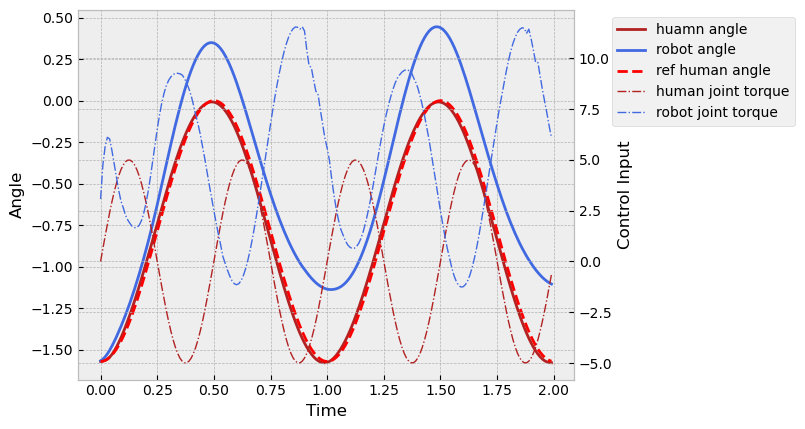

In [4]:
axs = plt.figure(figsize=(10,10))
# print x_traj values
#print(x_traj[:, 2])
print(des_angle)
ref = - np.pi/4 * np.cos(2*np.pi*np.arange(T)/100) - np.pi/4
human_u = 5 * np.sin(2 * 2 * np.pi * np.arange(T) / 100)

# create an array for the time steps
t = np.arange(T) / 100  # defined in hri.py, dt = 0.05
for i in range(n_batch):
    fig, ax1 = plt.subplots()  # Creates a new figure and a subplot
    
    # Plotting on the primary y-axis
    ax1.plot(t, x_traj[:, 2], color='firebrick')  # h th
    ax1.plot(t, x_traj[:, 10], color='royalblue')  # r th
    ax1.plot(t, ref, 'r--')  # ref
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Angle', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    
    # Creating a second y-axis for human_u and u_traj
    ax2 = ax1.twinx()  
    ax2.plot(t, human_u, color='firebrick', linestyle='-.', linewidth=1)  # human u
    ax2.plot(t, u_traj[:, 0].detach().numpy(), color='royalblue', linestyle='-.', linewidth=1)  # u1
    ax2.set_ylabel('Control Input', color='black')  
    ax2.tick_params(axis='y', labelcolor='black')
    
    # Adding a legend by creating custom lines and labels
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='firebrick', linestyle='-'),
                    Line2D([0], [0], color='royalblue', linestyle='-'),
                    Line2D([0], [0], color='r', linestyle='--'),
                    Line2D([0], [0], color='firebrick', linestyle='-.', linewidth=1),
                    Line2D([0], [0], color='royalblue', linestyle='-.', linewidth=1)]
    
    ax1.legend(custom_lines, ['huamn angle', 'robot angle', 'ref human angle', 'human joint torque', 'robot joint torque'], bbox_to_anchor=(1.46, 1), loc='upper right')
#plt.savefig('../results/MPC_CorrectModel_Sine.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
vid_fname = 'pendulum-{}.mp4'.format(mode)

if os.path.exists(vid_fname):
    os.remove(vid_fname)
    
cmd = 'ffmpeg -r 16 -f image2 -i {}/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(
    t_dir, vid_fname
)

os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [4]:
a = torch.tensor([20., 30., 40., 50., 60., 70., 80., 90., 100., 110.])
a[-3]

tensor(90.)